# Evaluating Predictive Performance

## Import required packages including DBMA

## HO1

Make sure DMBA package is available

In [2]:


import math
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pylab as plt

import dmba
from dmba import regressionSummary, classificationSummary, liftChart, gainsChart

%matplotlib inline

## Load file and generate training and validation sets. 

In [3]:

# Load data frame and select columns for regression analysis
car_df = dmba.load_data('ToyotaCorolla.csv')

# create a list of predictor variables by remvoing output variables and text columns
excludeColumns = ('Price', 'Id', 'Model', 'Fuel_Type', 'Color')
predictors = [s for s in car_df.columns if s not in excludeColumns]
outcome = 'Price'

# partition data
X = car_df[predictors]
y = car_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# train linear regression model
reg = LinearRegression()
reg.fit(train_X, train_y)

# evaluate performance
# training
regressionSummary(train_y, reg.predict(train_X))
# validation
regressionSummary(valid_y, reg.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1121.0606
            Mean Absolute Error (MAE) : 811.6770
          Mean Percentage Error (MPE) : -0.8630
Mean Absolute Percentage Error (MAPE) : 8.0054

Regression statistics

                      Mean Error (ME) : 97.1891
       Root Mean Squared Error (RMSE) : 1382.0352
            Mean Absolute Error (MAE) : 880.1396
          Mean Percentage Error (MPE) : 0.0138
Mean Absolute Percentage Error (MAPE) : 8.8744


## Prediction Error

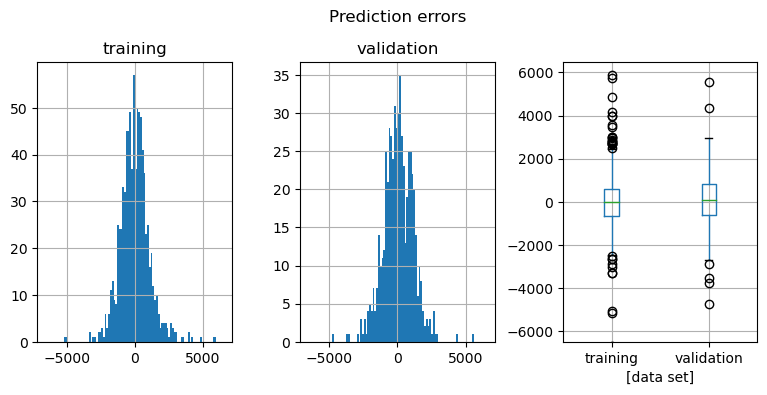

In [4]:

pred_error_train = pd.DataFrame({
    'residual': train_y - reg.predict(train_X), 
    'data set': 'training'
})
pred_error_valid = pd.DataFrame({
    'residual': valid_y - reg.predict(valid_X), 
    'data set': 'validation'
})
boxdata_df = pd.concat([pred_error_train, pred_error_valid])

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(9, 4)
common = {'bins': 100, 'range': [-6500, 6500]}
pred_error_train.hist(ax=axes[0], **common)
pred_error_valid.hist(ax=axes[1], **common)
boxdata_df.boxplot(ax=axes[2], by='data set')

axes[0].set_title('training')
axes[1].set_title('validation')
axes[2].set_title(' ')
axes[2].set_ylim(-6500, 6500)
plt.suptitle('Prediction errors') 
plt.subplots_adjust(bottom=0.15, top=0.85, wspace=0.35)

plt.show()

## Cumulative Gains and Lift Chart

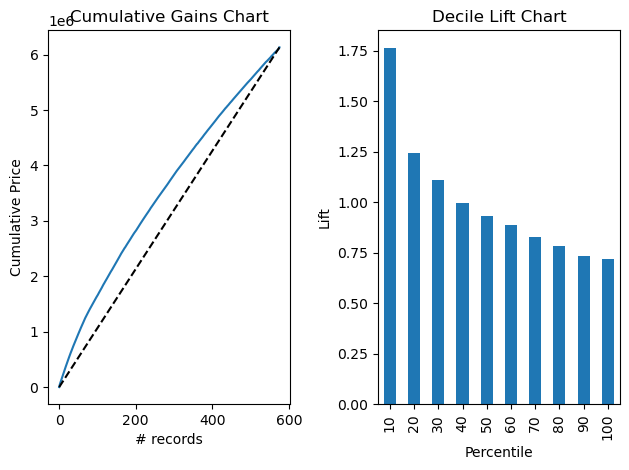

Lift based on meanResponse 1.7618191980414206
Expected cumulative price for 10% random sales 613291.8
Cumulative price for top 10% sales 1089905
Lift calculated based on gains chart 1.777139364980911


In [5]:

# sort the actual values in descending order of the prediction
df = pd.DataFrame({
    'predicted': reg.predict(valid_X),
    'actual': valid_y, 
})
df = df.sort_values(by=['predicted'], ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(df['actual'], ax=axes[0])
ax.set_ylabel('Cumulative Price')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(df['actual'], ax=axes[1], labelBars=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()


# group the sorted predictions into 10 roughly equal groups and calculate the mean
sorted_act_v = df['actual']
groups = [int(10 * i / len(sorted_act_v)) for i in range(len(sorted_act_v))]
meanPercentile = sorted_act_v.groupby(groups).mean()
meanResponse = meanPercentile / sorted_act_v.mean()
meanResponse.index = (meanResponse.index + 1) * 10
print('Lift based on meanResponse', meanResponse[10])
random10 = sorted_act_v.cumsum().iloc[-1] / 10  # expected cumulative price without lift for 10% sales
cumPred10 = sorted_act_v.cumsum().iloc[57]  # cumulative price based on model for top 10%
print('Expected cumulative price for 10% random sales', random10)
print('Cumulative price for top 10% sales', cumPred10)
print('Lift calculated based on gains chart', cumPred10 / random10)

## Confusion Matrix

In [6]:

owner_df = dmba.load_data('ownerExample.csv')
owner_df.head()
class_names = ['nonowner', 'owner']

In [7]:

predicted = ['owner' if p > 0.5 else 'nonowner' for p in owner_df.Probability]
classificationSummary(owner_df.Class, predicted, class_names=class_names)

Confusion Matrix (Accuracy 0.8750)

         Prediction
  Actual nonowner    owner
nonowner       10        2
   owner        1       11


In [8]:

predicted = ['owner' if p > 0.25 else 'nonowner' for p in owner_df.Probability]
classificationSummary(owner_df.Class, predicted, class_names=class_names)

Confusion Matrix (Accuracy 0.7917)

         Prediction
  Actual nonowner    owner
nonowner        8        4
   owner        1       11


In [9]:

predicted = ['owner' if p > 0.75 else 'nonowner' for p in owner_df.Probability]
classificationSummary(owner_df.Class, predicted, class_names=class_names)

Confusion Matrix (Accuracy 0.7500)

         Prediction
  Actual nonowner    owner
nonowner       11        1
   owner        5        7


## Calculate the accuracy at different cutoff values and create a graph.

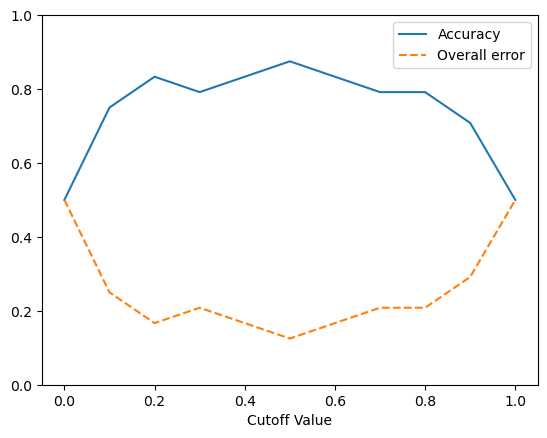

In [10]:

df = dmba.load_data('liftExample.csv')

cutoffs = [i * 0.1 for i in range(0, 11)]
accT = []
for cutoff in cutoffs:
    predicted = [1 if p > cutoff else 0 for p in df.prob]
    accT.append(accuracy_score(df.actual, predicted))

line_accuracy = plt.plot(cutoffs, accT, '-', label='Accuracy')[0]
line_error = plt.plot(cutoffs, [1 - acc for acc in accT], '--', label='Overall error')[0]
plt.ylim([0,1])
plt.xlabel('Cutoff Value')
plt.legend(handles=[line_accuracy, line_error])

plt.show()

## ROC

In [11]:

fpr, tpr, _ = roc_curve(df.actual, df.prob)
roc_auc = auc(fpr, tpr)

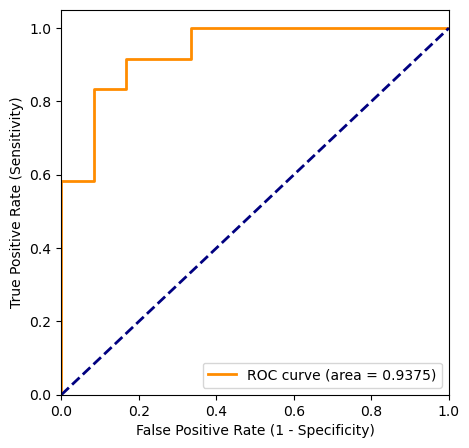

In [12]:

plt.figure(figsize=[5, 5])
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")

plt.show()

## Cumulative Gains

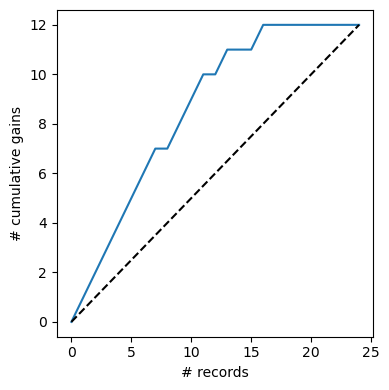

In [13]:

df = dmba.load_data('liftExample.csv')
df = df.sort_values(by=['prob'], ascending=False)

gainsChart(df.actual, figsize=(4, 4))

plt.tight_layout()
plt.show()

## Decile Lift Chart

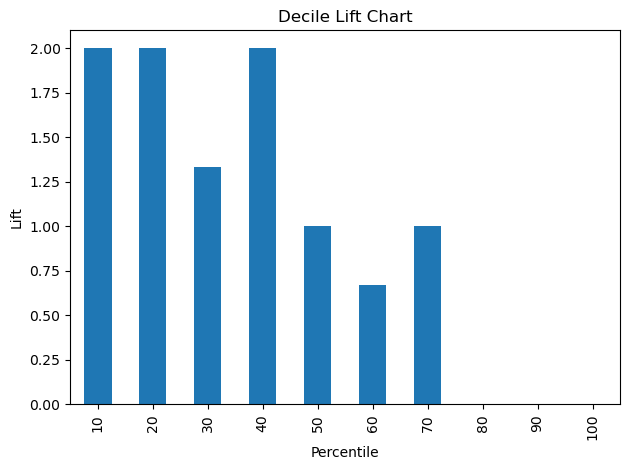

In [14]:

liftChart(df.actual, labelBars=False)
plt.tight_layout()
plt.show()

## HO2

In [1]:

from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pylab as plt

import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

%matplotlib inline

## Regression Fit Output

In [2]:

# Reduce data frame to the top 1000 rows and select columns for regression analysis
car_df = dmba.load_data('ToyotaCorolla.csv')
car_df = car_df.iloc[0:1000]

predictors = ['Age_08_04', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'CC', 
              'Doors', 'Quarterly_Tax', 'Weight']
outcome = 'Price'

# partition data
X = pd.get_dummies(car_df[predictors], drop_first=True)
y = car_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

car_lm = LinearRegression()
car_lm.fit(train_X, train_y)

# print coefficients
print('intercept ', car_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': car_lm.coef_}))

# print performance measures
regressionSummary(train_y, car_lm.predict(train_X))

intercept  -1319.3543800411808
           Predictor  coefficient
0          Age_08_04  -140.748761
1                 KM    -0.017840
2                 HP    36.103419
3          Met_Color    84.281830
4          Automatic   416.781954
5                 CC     0.017737
6              Doors   -50.657863
7      Quarterly_Tax    13.625325
8             Weight    13.038711
9   Fuel_Type_Diesel  1066.464681
10  Fuel_Type_Petrol  2310.249543

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1400.5823
            Mean Absolute Error (MAE) : 1046.9072
          Mean Percentage Error (MPE) : -1.0223
Mean Absolute Percentage Error (MAPE) : 9.2994


In [3]:
pred_y = car_lm.predict(train_X)

print('adjusted r2 : ', adjusted_r2_score(train_y, pred_y, car_lm))
print('AIC : ', AIC_score(train_y, pred_y, car_lm))
print('BIC : ', BIC_score(train_y, pred_y, car_lm))

adjusted r2 :  0.8537958550253093
AIC :  10422.298278332171
BIC :  10479.45836384998


## Predicted, Actual and Residuals

In [4]:

# Use predict() to make predictions on a new set
car_lm_pred = car_lm.predict(valid_X)

result = pd.DataFrame({'Predicted': car_lm_pred, 'Actual': valid_y,
                       'Residual': valid_y - car_lm_pred})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y, car_lm_pred)

        Predicted  Actual     Residual
507  10607.333940   11500   892.666060
818   9272.705792    8950  -322.705792
452  10617.947808   11450   832.052192
368  13600.396275   11450 -2150.396275
242  12396.694660   11950  -446.694660
929   9496.498212    9995   498.501788
262  12480.063217   13500  1019.936783
810   8834.146068    7950  -884.146068
318  12183.361282    9900 -2283.361282
49   19206.965683   21950  2743.034317
446  10987.498309   11950   962.501691
142  18501.527375   19950  1448.472625
968   9914.690947    9950    35.309053
345  13827.299932   14950  1122.700068
971   7966.732543   10495  2528.267457
133  17185.242041   15950 -1235.242041
104  19952.658062   19450  -502.658062
6    16570.609280   16900   329.390720
600  13739.409113   11250 -2489.409113
496  11267.513740   11750   482.486260

Regression statistics

                      Mean Error (ME) : 103.6803
       Root Mean Squared Error (RMSE) : 1312.8523
            Mean Absolute Error (MAE) : 1017.5972
        

## Residuals' histogram

0.7425


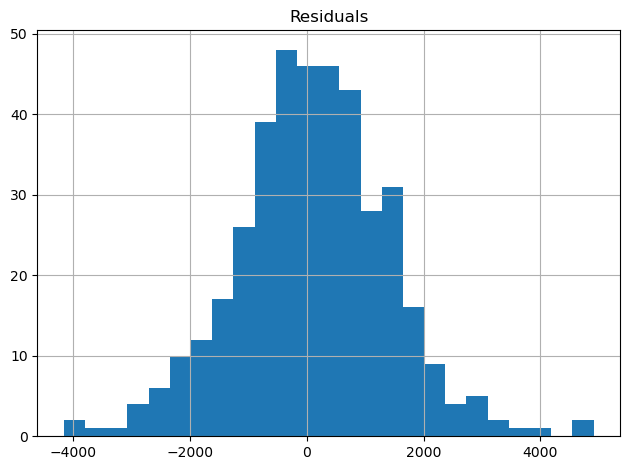

In [5]:

car_lm_pred = car_lm.predict(valid_X)
all_residuals = valid_y - car_lm_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

## Run an exhaustive search. The Fuel type column is categorical and needs to be converted into dummy variables.

In [6]:

def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))
pd.reset_option('display.width')

     n     r2adj           AIC  Age_08_04  Automatic     CC  Doors  Fuel_Type_Diesel  \
0    1  0.767901  10689.712094       True      False  False  False             False   
1    2  0.801160  10597.910645       True      False  False  False             False   
2    3  0.829659  10506.084235       True      False  False  False             False   
3    4  0.846357  10445.174820       True      False  False  False             False   
4    5  0.849044  10435.578836       True      False  False  False             False   
5    6  0.853172  10419.932278       True      False  False  False             False   
6    7  0.853860  10418.104025       True      False  False  False              True   
7    8  0.854297  10417.290103       True       True  False  False              True   
8    9  0.854172  10418.789079       True       True  False   True              True   
9   10  0.854036  10420.330800       True       True  False   True              True   
10  11  0.853796  10422.298278  

In [13]:

regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))


Regression statistics

                      Mean Error (ME) : 103.3045
       Root Mean Squared Error (RMSE) : 1314.4844
            Mean Absolute Error (MAE) : 1016.8875
          Mean Percentage Error (MPE) : -0.2700
Mean Absolute Percentage Error (MAPE) : 8.9984


## Backward elimination

## Forward selection

In [8]:

# The initial model is the constant model - this requires special handling
# in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: Age_08_04, KM, HP, Met_Color, Automatic, CC, Doors, Quarterly_Tax, Weight, Fuel_Type_Diesel, Fuel_Type_Petrol
Start: score=11565.07, constant
Step: score=10689.71, add Age_08_04
Step: score=10597.91, add HP
Step: score=10506.08, add Weight
Step: score=10445.17, add KM
Step: score=10435.58, add Quarterly_Tax
Step: score=10419.93, add Fuel_Type_Petrol
Step: score=10418.10, add Fuel_Type_Diesel
Step: score=10417.29, add Automatic
Step: score=10417.29, add None
['Age_08_04', 'HP', 'Weight', 'KM', 'Quarterly_Tax', 'Fuel_Type_Petrol', 'Fuel_Type_Diesel', 'Automatic']


In [9]:
#GV33
best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: Age_08_04, KM, HP, Met_Color, Automatic, CC, Doors, Quarterly_Tax, Weight, Fuel_Type_Diesel, Fuel_Type_Petrol
Start: score=11565.07, constant
Step: score=10689.71, add Age_08_04
Step: score=10597.91, add HP
Step: score=10506.08, add Weight
Step: score=10445.17, add KM
Step: score=10435.58, add Quarterly_Tax
Step: score=10419.93, add Fuel_Type_Petrol
Step: score=10418.10, add Fuel_Type_Diesel
Step: score=10417.29, add Automatic
Step: score=10417.29, unchanged None
['Age_08_04', 'HP', 'Weight', 'KM', 'Quarterly_Tax', 'Fuel_Type_Petrol', 'Fuel_Type_Diesel', 'Automatic']


## Regularized methods

In [10]:
#GV33
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

lasso = Pipeline([
    ['normalize', StandardScaler()],
    ['model', Lasso(alpha=1)],
])
lasso.fit(train_X, train_y)
regressionSummary(valid_y, lasso.predict(valid_X))

lasso_cv = Pipeline([
    ['normalize', StandardScaler()],
    ['model', LassoCV(cv=5)],
])
lasso_cv.fit(train_X, train_y)
regressionSummary(valid_y, lasso_cv.predict(valid_X))
print('Lasso-CV chosen regularization: ', lasso_cv['model'].alpha_)
print(lasso_cv['model'].coef_)

ridge = Pipeline([
    ['normalize', StandardScaler()],
    ['model', Ridge(alpha=1)],
])
ridge.fit(train_X, train_y)
regressionSummary(valid_y, ridge.predict(valid_X))

bayesianRidge = Pipeline([
    ['normalize', StandardScaler()],
    ['model', BayesianRidge()],
])
bayesianRidge.fit(train_X, train_y)
regressionSummary(valid_y, bayesianRidge.predict(valid_X))
print('Bayesian ridge chosen regularization: ', 
      bayesianRidge['model'].lambda_ / bayesianRidge['model'].alpha_)


Regression statistics

                      Mean Error (ME) : 104.4168
       Root Mean Squared Error (RMSE) : 1313.2944
            Mean Absolute Error (MAE) : 1017.6609
          Mean Percentage Error (MPE) : -0.2619
Mean Absolute Percentage Error (MAPE) : 9.0100

Regression statistics

                      Mean Error (ME) : 132.4317
       Root Mean Squared Error (RMSE) : 1360.7243
            Mean Absolute Error (MAE) : 1034.4871
          Mean Percentage Error (MPE) : -0.2610
Mean Absolute Percentage Error (MAPE) : 9.1337
Lasso-CV chosen regularization:  52.81252993972759
[-2344.72733104  -638.64821716   509.86847033     0.
    44.37403325     0.            -0.           299.72739261
   757.83746697    -0.           188.03203033]

Regression statistics

                      Mean Error (ME) : 104.3792
       Root Mean Squared Error (RMSE) : 1312.8865
            Mean Absolute Error (MAE) : 1017.4566
          Mean Percentage Error (MPE) : -0.2657
Mean Absolute Percentage Error 

In [11]:
#GV33
linearRegression = Pipeline([
    ['normalize', StandardScaler()],
    ['model', LinearRegression()],
])
linearRegression.fit(train_X, train_y)
regressionSummary(valid_y, linearRegression.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 103.6803
       Root Mean Squared Error (RMSE) : 1312.8523
            Mean Absolute Error (MAE) : 1017.5972
          Mean Percentage Error (MPE) : -0.2633
Mean Absolute Percentage Error (MAPE) : 9.0111


In [12]:
#GV33
pd.DataFrame({
    'features': train_X.columns, 
    'linear regression': linearRegression['model'].coef_, 
    'lassoCV': lasso_cv['model'].coef_, 
    'bayesianRidge': bayesianRidge['model'].coef_,
})

,features,linear regression,lassoCV,bayesianRidge
0,Age_08_04,-2346.564908,-2344.727331,-2329.981222
1,KM,-640.646815,-638.648217,-651.107146
2,HP,550.253745,509.868470,546.483948
3,Met_Color,39.094012,0.000000,39.468401
4,Automatic,96.361895,44.374033,94.470139
5,CC,10.966581,0.000000,12.616316
6,Doors,-47.961759,-0.000000,-45.367365
7,Quarterly_Tax,610.016332,299.727393,594.107204
8,Weight,770.715576,757.837467,775.190239
9,Fuel_Type_Diesel,358.655735,-0.000000,321.365335


## OLS results

In [ ]:
#GV33
# run a linear regression of Price on the remaining 11 predictors in the training set
train_df = train_X.join(train_y)

predictors = train_X.columns
formula = 'Price ~ ' + ' + '.join(predictors)

car_lm = sm.ols(formula=formula, data=train_df).fit()
print(car_lm.summary())

In [14]:
#GV33
car_df = dmba.load_data('ToyotaCorolla.csv')

In [15]:
#GV33
car_df.head()

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,...,1,1,0,0,0,1,0,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,...,0,1,0,0,0,1,0,0,0,0
2,3,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,...,0,1,0,0,0,1,0,0,0,0
3,4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,14950,26,7,2002,48000,Diesel,90,0,...,0,1,0,0,0,1,0,0,0,0
4,5,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,13750,30,3,2002,38500,Diesel,90,0,...,1,1,0,1,0,1,0,0,0,0


## HO3

### 6.1.a Why should the data be partitioned into training and validation sets? What will the
### training set be used for? What will the validation set be used for?


Splitting data into training and validation sets plays a crucial role in machine learning. The training set educates the model on data patterns, thereby improving prediction accuracy. Conversely, the validation set scrutinizes the model's performance on fresh data, uncovering overfitting and enabling fine-tuning of hyperparameters. This division safeguards against subpar generalization, upholds data integrity, and guarantees a dependable model evaluation prior to deployment.

### b. Fit a multiple linear regression model to the median house price (MEDV) as a function of CRIM, CHAS, and RM. Write the equation for predicting the median house price from the predictors in the model.


In [3]:
# Load the Boston Housing dataset from a CSV file
boston_data = dmba.load_data('BostonHousing.csv')

# Define a list of predictor variables by excluding output variables and text columns
selected_features = ('CRIM', 'CHAS', 'RM')
predictors = [col for col in boston_data.columns if col in selected_features]
target_variable = 'MEDV'

# Partition the data into training and validation sets
X = boston_data[predictors]
y = boston_data[target_variable]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=1)

# Create and train a linear regression model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

# Evaluate the model's performance
# Training set evaluation
print("Performance on the Training Set:")
regressionSummary(y_train, linear_reg_model.predict(X_train))

# Validation set evaluation
print("\nPerformance on the Validation Set:")
regressionSummary(y_valid, linear_reg_model.predict(X_valid))


Performance on the Training Set:

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 5.9666
            Mean Absolute Error (MAE) : 3.9668
          Mean Percentage Error (MPE) : -7.2747
Mean Absolute Percentage Error (MAPE) : 22.5927

Performance on the Validation Set:

Regression statistics

                      Mean Error (ME) : 0.1174
       Root Mean Squared Error (RMSE) : 6.4125
            Mean Absolute Error (MAE) : 4.4558
          Mean Percentage Error (MPE) : -7.6160
Mean Absolute Percentage Error (MAPE) : 23.1676


In [8]:
#GV33
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': linear_reg_model.coef_}))
print('intercept ', linear_reg_model.intercept_)


  Predictor  coefficient
0      CRIM    -0.240062
1      CHAS     3.266817
2        RM     8.325175
intercept  -29.19346743060684



 MEDV =  -29.193  -0.24 * CRIM  + 3.27 * CHAS + 8.33 * RM

## c. Using the estimated regression model, what median house price is predicted for atract in the Boston area that does not bound the Charles River, has a crime rate of 0.1, and where the average number of rooms per house is 6?

= -29.19 -0.24 * 0.1+ 3.27 * 0  + 8.33 * 6 = 20.766
 
 Ans:  20.77 thousand dollars

## HO4

6.4 Predicting Prices of Used Cars. The file ToyotaCorolla.csv contains data on used
cars (Toyota Corolla) on sale during late summer of 2004 in the Netherlands. It has
1436 records containing details on 38 attributes, including Price, Age, Kilometers,
HP, and other specifications. The goal is to predict the price of a used Toyota Corolla
based on its specifications. (The example in Section 6.3 is a subset of this dataset.)
Split the data into training (50%), validation (30%), and test (20%) datasets.
Run a multiple linear regression with the outcome variable Price and predictor variables Age_08_04, KM, Fuel_Type, HP, Automatic, Doors, Quarterly_Tax, Mfr_Guarantee, Guarantee_Period, Airco, Automatic_airco, CD_Player,
Powered_Windows, Sport_Model, and Tow_Bar.


In [63]:
#GV33
car_df = dmba.load_data('ToyotaCorolla.csv')

predictors = ['Age_08_04', 'KM', 'Fuel_Type', 'HP', 'Automatic', 'Doors', 'Quarterly_Tax', 'Mfr_Guarantee', 
              'Guarantee_Period', 'Airco', 'Automatic_airco', 'CD_Player',
            'Powered_Windows', 'Sport_Model','Tow_Bar']
outcome = 'Price'

In [64]:
#GV33
X = pd.get_dummies(car_df[predictors], drop_first=True)
y = car_df[outcome]

In [67]:
#GV33
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


print("\nNormalized DataFrame:")
print(X)


Normalized DataFrame:
      Age_08_04        KM        HP  Automatic     Doors  Quarterly_Tax  \
0      0.278481  0.193355  0.170732        0.0  0.333333       0.723485   
1      0.278481  0.300149  0.170732        0.0  0.333333       0.723485   
2      0.291139  0.171647  0.170732        0.0  0.333333       0.723485   
3      0.316456  0.197528  0.170732        0.0  0.333333       0.723485   
4      0.367089  0.158433  0.170732        0.0  0.333333       0.723485   
...         ...       ...       ...        ...       ...            ...   
1431   0.860759  0.084539  0.138211        0.0  0.333333       0.189394   
1432   0.898734  0.078186  0.138211        0.0  0.333333       0.189394   
1433   0.886076  0.070021  0.138211        0.0  0.333333       0.189394   
1434   0.873418  0.069609  0.138211        0.0  0.333333       0.189394   
1435   0.949367  0.000000  0.333333        0.0  1.000000       0.000000   

      Mfr_Guarantee  Guarantee_Period  Airco  Automatic_airco  CD_Player  \


In [68]:
#GV33
X.head()

,Age_08_04,KM,HP,Automatic,Doors,Quarterly_Tax,Mfr_Guarantee,Guarantee_Period,Airco,Automatic_airco,CD_Player,Powered_Windows,Sport_Model,Tow_Bar,Fuel_Type_Diesel,Fuel_Type_Petrol
0,0.278481,0.193355,0.170732,0.0,0.333333,0.723485,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.278481,0.300149,0.170732,0.0,0.333333,0.723485,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.291139,0.171647,0.170732,0.0,0.333333,0.723485,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.316456,0.197528,0.170732,0.0,0.333333,0.723485,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.367089,0.158433,0.170732,0.0,0.333333,0.723485,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [69]:
#GV33
train_prop = 0.5  
val_prop = 0.3    
test_prop = 0.2   

# Spliting the data into training, validation, and test sets for both X and y
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_prop, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_prop / (test_prop + val_prop), random_state=42)


In [70]:
#GV33
car_lm = LinearRegression()
car_lm.fit(X_train, y_train)

LinearRegression()

In [80]:
#GV33
print('intercept ', car_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': car_lm.coef_}))

intercept  12765.411795273496
           Predictor  coefficient
0          Age_08_04 -8587.665727
1                 KM -4306.210176
2                 HP  3999.006395
3          Automatic   577.899481
4              Doors   584.640625
5      Quarterly_Tax  4089.757117
6      Mfr_Guarantee   277.396627
7   Guarantee_Period  2249.299199
8              Airco   246.572488
9    Automatic_airco  2854.155367
10         CD_Player   362.275419
11   Powered_Windows   419.159345
12       Sport_Model   396.351672
13           Tow_Bar  -256.982042
14  Fuel_Type_Diesel  1847.177000
15  Fuel_Type_Petrol  1856.125659


###  What appear to be the three or four most important car specifications for predictingthe car’s price? 
based on co efficent weightrs AGE of the car, KM- Distance travelled by car, HP- Horse power of car, Quarterly road tax are 4 most important car specifications for predictingthe car’s price

### b. Using metrics you consider useful, assess the performance of the model in predicting prices.

In [81]:
#GV33 
#printring performance =
print("Training set performance")
regressionSummary(y_train, car_lm.predict(X_train))


 Training performance

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1163.2637
            Mean Absolute Error (MAE) : 891.9649
          Mean Percentage Error (MPE) : -1.0593
Mean Absolute Percentage Error (MAPE) : 9.0154


In [82]:
#GV33
print("Validation set performance")
regressionSummary(y_val, car_lm.predict(X_val))

Validation set performance

Regression statistics

                      Mean Error (ME) : -86.4952
       Root Mean Squared Error (RMSE) : 1271.2089
            Mean Absolute Error (MAE) : 911.8754
          Mean Percentage Error (MPE) : -1.8400
Mean Absolute Percentage Error (MAPE) : 8.8202


In [83]:
#GV33
print("TEst set prediction")
car_lm.predict(X_test)

TEst set prediction


array([ 8075.56933611, 10292.9588751 , 10294.7650823 , 11449.99608045,
        7770.43524823, 12741.00656751,  8487.8934537 ,  9573.59074054,
       10683.10326396, 10187.61787947,  7007.18634001,  6545.96350477,
        7610.25564146,  7918.71510309, 11546.81694809,  9891.91428085,
        8992.8892512 ,  9513.78852359, 15134.57688613,  9995.48504348,
        6423.57239077,  9791.79109791, 10734.4617831 ,  9979.7298388 ,
       10741.26194701, 14739.4276143 ,  7601.73771825, 12952.95147988,
       10958.63956786,  9314.87596137,  8342.22780738, 12945.60262121,
        9430.1725042 ,  7054.95602516,  8444.63301889, 16375.06132733,
        7732.30770648, 14324.73322041, 11165.26150864,  8034.86524252,
       10353.41555434, 10440.52299022,  8548.66282251, 10572.82593031,
       10968.29266257, 13504.06500493, 11508.75149661, 12732.40408428,
        9375.12197097,  8516.02988807,  9096.88003896, 10172.19661355,
        6860.08597431, 11126.92751599, 16366.53344495,  8284.12651585,
      

### Estimate the “rating” using cereal breakfast data set after Removing categorical variables. What is the R-squared value and how do you interpret it? How many of the independent variables are significant at 5% based on your estimation results

In [26]:
#GV33
cereals_df = dmba.load_data('Cereals.csv')

In [27]:
#GV33
cereals_df.head(9)

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100%_Bran,N,C,70,4,1,130,10.0,5.0,6.0,280.0,25,3,1.00,0.33,68.402973
1,100%_Natural_Bran,Q,C,120,3,5,15,2.0,8.0,8.0,135.0,0,3,1.00,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5.0,320.0,25,3,1.00,0.33,59.425505
3,All-Bran_with_Extra_Fiber,K,C,50,4,0,140,14.0,8.0,0.0,330.0,25,3,1.00,0.50,93.704912
4,Almond_Delight,R,C,110,2,2,200,1.0,14.0,8.0,NaN,25,3,1.00,0.75,34.384843
5,Apple_Cinnamon_Cheerios,G,C,110,2,2,180,1.5,10.5,10.0,70.0,25,1,1.00,0.75,29.509541
6,Apple_Jacks,K,C,110,2,0,125,1.0,11.0,14.0,30.0,25,2,1.00,1.00,33.174094
7,Basic_4,G,C,130,3,2,210,2.0,18.0,8.0,100.0,25,3,1.33,0.75,37.038562
8,Bran_Chex,R,C,90,2,1,200,4.0,15.0,6.0,125.0,25,1,1.00,0.67,49.120253


In [28]:
#GV33
columns_remove = ['name','mfr','type','shelf','vitamins']
ud_cereals_df = cereals_df.drop(columns=columns_remove)
ud_cereals_df.head(9)

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,weight,cups,rating
0,70,4,1,130,10.0,5.0,6.0,280.0,1.00,0.33,68.402973
1,120,3,5,15,2.0,8.0,8.0,135.0,1.00,1.00,33.983679
2,70,4,1,260,9.0,7.0,5.0,320.0,1.00,0.33,59.425505
3,50,4,0,140,14.0,8.0,0.0,330.0,1.00,0.50,93.704912
4,110,2,2,200,1.0,14.0,8.0,NaN,1.00,0.75,34.384843
5,110,2,2,180,1.5,10.5,10.0,70.0,1.00,0.75,29.509541
6,110,2,0,125,1.0,11.0,14.0,30.0,1.00,1.00,33.174094
7,130,3,2,210,2.0,18.0,8.0,100.0,1.33,0.75,37.038562
8,90,2,1,200,4.0,15.0,6.0,125.0,1.00,0.67,49.120253


In [33]:
#GV33
ud_cereals_df.head(9)

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,weight,cups,rating
0,70,4,1,130,10.0,5.0,6.0,280.0,1.00,0.33,68.402973
1,120,3,5,15,2.0,8.0,8.0,135.0,1.00,1.00,33.983679
2,70,4,1,260,9.0,7.0,5.0,320.0,1.00,0.33,59.425505
3,50,4,0,140,14.0,8.0,0.0,330.0,1.00,0.50,93.704912
4,110,2,2,200,1.0,14.0,8.0,NaN,1.00,0.75,34.384843
5,110,2,2,180,1.5,10.5,10.0,70.0,1.00,0.75,29.509541
6,110,2,0,125,1.0,11.0,14.0,30.0,1.00,1.00,33.174094
7,130,3,2,210,2.0,18.0,8.0,100.0,1.33,0.75,37.038562
8,90,2,1,200,4.0,15.0,6.0,125.0,1.00,0.67,49.120253


In [29]:
#GV33
train_y = ud_cereals_df['rating']

train_y

0     68.402973
1     33.983679
2     59.425505
3     93.704912
4     34.384843
        ...    
72    39.106174
73    27.753301
74    49.787445
75    51.592193
76    36.187559
Name: rating, Length: 77, dtype: float64

In [35]:
#GV33
train_X = ud_cereals_df.drop(columns=['rating'])
train_X.isnull().sum()

calories    0
protein     0
fat         0
sodium      0
fiber       0
carbo       1
sugars      1
potass      2
weight      0
cups        0
dtype: int64

In [36]:
#GV33
mean_value = train_X['potass'].mean()
train_X['potass'].fillna(mean_value, inplace=True)

In [37]:
#GV33
mean_value = train_X['sugars'].mean()
train_X['sugars'].fillna(mean_value, inplace=True)

In [38]:
#GV33
mean_value = train_X['carbo'].mean()
train_X['carbo'].fillna(mean_value, inplace=True)

In [46]:
#GV33
ud_cereals_df_lm = LinearRegression()
a=ud_cereals_df_lm.fit(train_X, train_y)

# printing coefficients
print('intercept ', ud_cereals_df_lm.intercept_)

# printing performance measures
regressionSummary(train_y, ud_cereals_df_lm.predict(train_X))

intercept  58.028661667238936

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1.4667
            Mean Absolute Error (MAE) : 0.9576
          Mean Percentage Error (MPE) : -0.1065
Mean Absolute Percentage Error (MAPE) : 2.3478


In [84]:
#GV33
pred_y = ud_cereals_df_lm.predict(train_X)

print('adjusted r2 : ', adjusted_r2_score(train_y, pred_y, ud_cereals_df_lm))
print('AIC : ', AIC_score(train_y, pred_y, ud_cereals_df_lm))
print('BIC : ', BIC_score(train_y, pred_y, ud_cereals_df_lm))

adjusted r2 :  0.9872806017697889
AIC :  301.5047787674782
BIC :  329.63044382972237


### What is the R-squared value and how do you interpret it
 R-squared value is 0.9873 which means that 98.73% variation in the data is explained by model

In [56]:

residuals = train_y - pred_y

# Calculate the standard errors of the coefficients
mse = ((residuals ** 2).sum()) / (len(train_X) - len(train_X.columns))
se = np.array([np.sqrt(np.diagonal(mse * np.linalg.inv(np.dot(train_X.T, train_X))))])

# Calculate t-statistics
t_stats = ud_cereals_df_lm.coef_ / se

# Calculate p-values
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), len(train_X) - 1))

# Set the significance level
alpha = 0.05

# Count the number of significant independent variables
significant_vars = (p_values < alpha).sum()

print("Number of significant independent variables at 5% significance level:", significant_vars)


Number of significant independent variables at 5% significance level: 7


### How many of the independent variables are significant at 5% based on your estimation result
7  variables

## Hand on 6

### CSV File for Evaluation Metrics Exercise, Module 3" includes actual Y values in addition to predictions of these by three models (i.e. Models 1, 2, and 3). Use MAD, MAPE and RMSE to compare these three models. Which model is the best predictor based on these metrics? 

In [9]:
#GV33
df = pd.read_csv('CSV File for Evaluation Metrics Exercise, Module 3.csv')

In [10]:
#GV33
df.head()

,Index,Actual Y,Model 1 Prediction of Y,Model 2 Prediction of Y,Model 3 Prediction of Y
0,1,41,81,60,53
1,2,85,7,9,59
2,3,75,77,56,30
3,4,80,36,96,88
4,5,33,65,76,56


In [12]:
#GV33
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Define functions to calculate MAD, MAPE, and RMSE
def calculate_metrics(true_values, predicted_values):
    mad = np.mean(np.abs(true_values - predicted_values))
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    return mad, mape, rmse

# Calculate metrics for each model
actual_values = df['Actual Y']
model1_predicted_values = df['Model 1 Prediction of Y']
model2_predicted_values = df['Model 2 Prediction of Y']
model3_predicted_values = df['Model 3 Prediction of Y']

model1_mad, model1_mape, model1_rmse = calculate_metrics(actual_values, model1_predicted_values)
model2_mad, model2_mape, model2_rmse = calculate_metrics(actual_values, model2_predicted_values)
model3_mad, model3_mape, model3_rmse = calculate_metrics(actual_values, model3_predicted_values)

# Create a DataFrame to compare metrics
metrics_df = pd.DataFrame({
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'Mean Absolute Deviation (MAD)': [model1_mad, model2_mad, model3_mad],
    'Mean Absolute Percentage Error (MAPE) (%)': [model1_mape, model2_mape, model3_mape],
    'Root Mean Squared Error (RMSE)': [model1_rmse, model2_rmse, model3_rmse]
})

# Determine the best model based on the RMSE metric
best_model = metrics_df.loc[metrics_df['Root Mean Squared Error (RMSE)'].idxmin()]

print("Comparison of Models Based on Evaluation Metrics:")
print(metrics_df)
print("\nBest Model Based on RMSE:")
print(best_model)


Comparison of Models Based on Evaluation Metrics:
     Model  Mean Absolute Deviation (MAD)  \
0  Model 1                          38.93   
1  Model 2                          34.13   
2  Model 3                          34.17   

   Mean Absolute Percentage Error (MAPE) (%)  Root Mean Squared Error (RMSE)  
0                                 139.308421                       46.659726  
1                                 107.172246                       41.490119  
2                                 119.930747                       41.953665  

Best Model Based on RMSE:
Model                                           Model 2
Mean Absolute Deviation (MAD)                     34.13
Mean Absolute Percentage Error (MAPE) (%)    107.172246
Root Mean Squared Error (RMSE)                41.490119
Name: 1, dtype: object


### Which model is the best predictor based on these metrics
model 2 